# Turnover

The goal of this notebook is to predict the turnover of the company described by the HR.csv dataset.
This dataset was found on Kaggle: https://www.kaggle.com/colara/human-resource

## Summary
1. Exploration
2. Data cleaning/Preprocessing
3. Feature Engineering
4. Model tuning
5. Postprocessing

In [1]:
# Imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm as cm

In [2]:
import math

In [35]:
# Load
df=pd.read_csv('HR_comma_sep.csv')
df.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


## 1. Exploration

In [36]:
# Features
features=[k for k in df.columns]

In [37]:
# statistics
df.describe(include = 'all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999,14999
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4140,7316
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


On average:
- employees have a satisfaction rate of 0.61, not bad but quite low if you expect people to be happy at work;
  they had good grades at their last evaluation (0.72);
  they work on more than 3 projects;
  they spend 7 hours per day at the office;
  they have been in the company for 3 years and a half;
- work accidents are rare;
- few employees got a promotion in the last 5 years: 2% of the staff, this is very low!

20% of the employees want to leave the company
    
Our goal: 
- explain why they want to leave,
- find which categories of employees want to leave
- train a model able to predict who will leave the company
- evaluate the performances of this model

#### Data visualization

In [38]:
# to add

In [39]:
#### hypothesis => to add
(source: Kaggle link)

SyntaxError: invalid syntax (<ipython-input-39-c0fb6fe70b7b>, line 2)

Conclusion:
- the salary does not have an impact on the turnover
- people who leave either have very few projects or a lot of projects
- people tend to leave the company after 3 years at the company
- employees with a higher salary are less likely to leave the company (?)

Interpretation:
- a promotion is a reward that too few employees were given, so they are less motivated
- people with too few projects want to find something more interesting elsewhere
- people with too many projects and who spend too much time at work wish to have a more balanced lifestyle
- salaries (?)

## 2. Preprocessing

Data already clean, no missing values or typo errors in the data itself;
Note1: 'sales' should be renamed 'department'
Note2: 'average_monthly_hours' (with h)
Note3: 'work_accident' (w instead of W, for homogeneity)
All features are numerics, except 'sales' and 'salary'

In [40]:
# Rename 'Sales' to 'Department'
df.rename(columns = {'sales':'department'}, inplace = True)
# Rename 'average_montly_hours' to 'average_monthly_hours'
df.rename(columns = {'average_montly_hours':'average_monthly_hours'}, inplace = True)
# Rename 'Work_accident' to 'work_accident'
df.rename(columns = {'Work_accident':'work_accident'}, inplace = True)

In [41]:
# Convert Department into a numeric feature

# Step1: rank the departments according to their turnover rate
df[['department', 'left']].groupby(['department'], as_index=False).mean().sort_values(by='left', ascending=False)

,department,left
3,hr,0.290934
2,accounting,0.265971
9,technical,0.256250
8,support,0.248991
7,sales,0.244928
5,marketing,0.236597
0,IT,0.222494
6,product_mng,0.219512
1,RandD,0.153748
4,management,0.144444


In [42]:
# Step2: transposition on the basis of the ranking
df=df.replace(['hr', 'accounting', 'technical', 'support', 'sales', 'marketing', 'IT', 'product_mng', 'RandD', 'management'], [0,1,2,3,4,5,6,7,8,9])

In [43]:
# Convert salary into numerics

# Step1: ranking
df[['salary', 'left']].groupby(['salary'], as_index=False).mean().sort_values(by='left', ascending=False)

,salary,left
1,low,0.296884
2,medium,0.204313
0,high,0.066289


In [44]:
#Step2: transposition
df=df.replace(['low', 'medium', 'high'], [0,1,2])

In [45]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,4,0
1,0.80,0.86,5,262,6,0,1,0,4,1
2,0.11,0.88,7,272,4,0,1,0,4,1
3,0.72,0.87,5,223,5,0,1,0,4,0
4,0.37,0.52,2,159,3,0,1,0,4,0


## 3. Feature engineering

In [46]:
# Correlation matrix

df.corr()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605,0.025580,0.050022
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684,-0.002591,-0.013002
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064,0.006400,-0.001803
average_monthly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544,-0.001292,-0.002242
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433,0.064163,0.048715
work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245,0.021349,0.009247
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788,-0.070018,-0.157898
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000,0.070088,0.098119
department,0.025580,-0.002591,0.006400,-0.001292,0.064163,0.021349,-0.070018,0.070088,1.000000,0.073555
salary,0.050022,-0.013002,-0.001803,-0.002242,0.048715,0.009247,-0.157898,0.098119,0.073555,1.000000


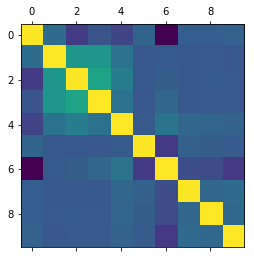

In [47]:
plt.matshow(df.corr())
plt.show()

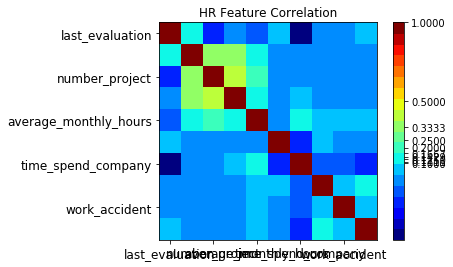

In [48]:
def corr_M(df0):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 20)
    cax = ax1.imshow(df0.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(False)
    plt.title('HR Feature Correlation')
    labels=df0.columns
    ax1.set_xticklabels(labels,fontsize=12)
    ax1.set_yticklabels(labels,fontsize=12)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[1/k for k in range(1,11)])
    plt.show()
    
corr_M(df)

#### New features :

How does the employee feel?

- investment (or workload) : average_monthly_hours * number_project
- reward : promotion + salary (+last_evaluation?)
- sanity : investment, satisfaction_level, work_accident (+reward) => voir selon les services d’activité)


Is he a valuable member of the community?
- efficiency : number_project / average_monthly_hours
- experience : number of projects * time spent in the company)

In [50]:
def create_investment(dtf):
    dtf['investment']=dtf['number_project']*dtf['average_monthly_hours']
    return dtf

create_investment(df);

In [51]:
def create_reward(dtf):
    dtf['reward']=dtf['promotion_last_5years']+dtf['salary']
    return dtf

create_reward(df).head();

In [54]:
print(df.median()['work_accident'])
print(df.median()['satisfaction_level'])

0.0
0.64


In [56]:
df.mean()

satisfaction_level         0.612834
last_evaluation            0.716102
number_project             3.803054
average_monthly_hours    201.050337
time_spend_company         3.498233
work_accident              0.144610
left                       0.238083
promotion_last_5years      0.021268
department                 3.959331
salary                     0.594706
investment               790.286752
reward                     0.615974
dtype: float64

In [58]:
# to modify

def create_sanity(dtf):
    med=dtf.median()['investment']
    dtf['sanity'] = (1+dtf['satisfaction_level']) / ((1+dtf['work_accident'])*(1+(dtf['investment']-med)**2))
    return dtf
                                                    
# hypothesis: being moderatly invested is a factor of sanity 
# because it leaves time and energy for other fulfilling activities

create_sanity(df).head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary,investment,reward,sanity
0,0.38,0.53,2,157,3,0,1,0,4,0,314,0,8.012727e-06
1,0.80,0.86,5,262,6,0,1,0,4,1,1310,1,5.332354e-06
2,0.11,0.88,7,272,4,0,1,0,4,1,1904,1,8.039831e-07
3,0.72,0.87,5,223,5,0,1,0,4,0,1115,0,1.154386e-05
4,0.37,0.52,2,159,3,0,1,0,4,0,318,0,8.110252e-06


In [57]:
def create_experience(dtf):
    dtf['experience']=dtf['number_project']*dtf['time_spend_company']
    return dtf
create_experience(df);

In [58]:
def create_efficiency(dtf):
    dtf['efficiency']=dtf['number_project']/dtf['average_monthly_hours']
    return dtf

create_efficiency(df);    

In [ ]:
4. Model tuning

In [102]:
# test if better with minmax sclaing or with normalization (see report Assgn2)

# -*- coding: utf-8 -*-
import pandas as pd, numpy as np

# Read recipe inputs
hr_train=pd.read_csv('HR_train.csv')

hr_test=pd.read_csv('HR_test.csv')

In [ ]:
hr_train


In [120]:
from sklearn.preprocessing import StandardScaler

#-- Model import --#
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier

from matplotlib import pyplot as plt

from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV

from time import time


A ce stade on a divisé le dataset en un training set et un testing set. Feature à prédire: left (0: still in the company, 1: resigned) 
    Il faut extraire la colonne left du testing set. On la conserve pour pouvoir calculer l'accuracy.

In [104]:
train_left, test_left = hr_train['left'], hr_test['left']
del hr_train['left']
del hr_test['left']

In [105]:
def normalize(dtf):
    return (dtf-dtf.mean())/dtf.std()

In [106]:
normalized_train=normalize(hr_train)
normalized_test=normalize(hr_test)

In [107]:
normalized_test.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,promotion_last_5years,department,salary,investment,reward,sanity,experience,efficiency
0,-0.769106,1.121046,-0.678015,0.158966,-1.047153,-0.415612,-0.130167,-0.912622,-0.927185,-0.440417,-0.921443,-0.081176,-0.972624,-0.766578
1,0.467484,0.889401,0.131072,1.249292,-1.047153,-0.415612,-0.130167,-0.459483,-0.927185,0.666302,-0.921443,-0.082554,-0.718354,-0.645202
2,0.108474,0.426111,0.131072,-1.254421,-0.333023,-0.415612,-0.130167,-0.006344,-0.927185,-0.625304,-0.921443,-0.082115,-0.209815,1.280765
3,0.228144,-0.210913,0.131072,-0.608301,-0.333023,-0.415612,-0.130167,-0.006344,-0.927185,-0.291986,-0.921443,-0.073273,-0.209815,0.516337
4,0.507374,1.294779,-0.678015,1.713691,1.809368,-0.415612,7.679865,-0.912622,0.639006,0.161117,2.106300,-0.081543,0.552994,-1.315155


In [108]:
normalized_train.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,promotion_last_5years,department,salary,investment,reward,sanity,experience,efficiency
0,-1.825058,1.311369,-0.644923,-0.460175,0.33485,-0.410016,-0.151429,-1.772988,0.635311,-0.662950,0.571650,-0.078246,-0.206844,-0.386091
1,-0.817496,0.725879,1.790843,-0.200428,1.69109,-0.410016,-0.151429,-1.772988,0.635311,0.929214,0.571650,-0.078530,2.783578,1.734276
2,0.431880,0.257486,-0.644923,1.198208,0.33485,-0.410016,-0.151429,0.923119,0.635311,-0.015158,0.571650,-0.071139,-0.206844,-1.166636
3,0.472183,0.374584,-0.644923,1.218189,2.36921,2.438727,6.603205,2.271173,2.205465,-0.007353,3.563025,-0.075251,0.914564,-1.173025
4,-0.736891,-1.089143,-1.456845,-1.299356,-0.34327,-0.410016,-0.151429,0.024417,0.635311,-1.344562,0.571650,-0.078546,-0.954450,-0.698918


In [109]:
X_train = normalized_train.values
Y_train = train_left.values

X_test = normalized_test.values
Y_test = test_left.values

In [110]:
Y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [113]:
#LOGISTIC REGRESSION

clf = LogisticRegression().fit(X_train, Y_train)

clf.score(X_test, Y_test)

0.8976666666666666

In [128]:
#KNN
neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(X_train, Y_train)

Y_pred = neigh.predict(X_test)

print(f1_score(Y_test, Y_pred, average='micro'))

0.9433333333333332


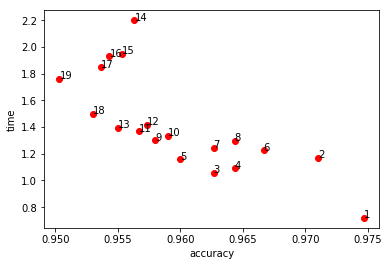

In [127]:
for n in range(1, 20):
    t = time()
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train, Y_train)
    Y_pred = neigh.predict(X_test)
    score = f1_score(Y_test, Y_pred, average='micro')
    tim = time()-t
    plt.plot(score, tim, 'ro')
    plt.annotate(str(n), (score, tim))
    
plt.xlabel('accuracy')
plt.ylabel('time')
plt.show()

In [129]:
#SVM
clf = SVC(gamma='auto')
clf.fit(X_train, Y_train) 
Y_pred = clf.predict(X_test)
print(f1_score(Y_test, Y_pred, average='micro'))

0.961


In [130]:
#Decision Tree Classifier
DTC = DecisionTreeClassifier(random_state=0)
DTC.fit(X_train, Y_train) 
Y_pred = DTC.predict(X_test)
print(f1_score(Y_test, Y_pred, average='micro'))

0.9436666666666667


In [134]:
#Random Forrest 
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(f1_score(Y_test, Y_pred, average='micro'))

0.958


In [135]:
#Extra Trees
clf = ExtraTreesClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(f1_score(Y_test, Y_pred, average='micro'))

0.9813333333333333


In [137]:
#ADA Boost

clf = AdaBoostClassifier(ExtraTreesClassifier())
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(f1_score(Y_test, Y_pred, average='micro'))

0.9743333333333334


In [139]:
#Gradient Boosting
clf = GradientBoostingClassifier()
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(f1_score(Y_test, Y_pred, average='micro'))

0.9533333333333334


In [146]:
import operator

def classification_auto(X_train, Y_train, X_test, Y_test, n_neighbors=50):
    clasf = {}
    
    logreg = LogisticRegression().fit(X_train, Y_train)
    clasf['LogisticRegression'] = (logreg.score(X_test, Y_test), logreg.predict(X_test))
    
    knn = KNeighborsClassifier(n_neighbors).fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    clasf['KNN'] = (f1_score(Y_test, Y_pred, average='micro'), Y_pred)
    
    clf = SVC(gamma='auto')
    clf.fit(X_train, Y_train) 
    Y_pred = clf.predict(X_test)
    clasf['SVM'] =(f1_score(Y_test, Y_pred, average='micro'),Y_pred)
    
    DTC = DecisionTreeClassifier(random_state=0)
    DTC.fit(X_train, Y_train) 
    Y_pred = DTC.predict(X_test)
    clasf['DecisionTree']= (f1_score(Y_test, Y_pred, average='micro'), Y_pred)

    clf = RandomForestClassifier()
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    clasf['RandomForrest']= (f1_score(Y_test, Y_pred, average='micro'), Y_pred)

    clf = ExtraTreesClassifier()
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    clasf['ExtraTrees']= (f1_score(Y_test, Y_pred, average='micro'), Y_pred)
    
    clf = GradientBoostingClassifier()
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    clasf['GradientBoost']= (f1_score(Y_test, Y_pred, average='micro'), Y_pred)
    
    return sorted(clasf.items(), key=lambda x: x[1][0])[-1]       

In [147]:
classification_auto(X_train, Y_train, X_test, Y_test)

('ExtraTrees', (0.982, array([0, 0, 0, ..., 0, 0, 1], dtype=int64)))

In [ ]:
5. Postprocessing